In [1]:
# Load the useful packages
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import os
import sklearn
import seaborn as sns # visualization
import matplotlib.pyplot as plt # plotting
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Common Model Algorithms
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

#Common Model Helpers
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV   #Performing grid search
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

sns.set(style="darkgrid")

In [2]:
# Input data files are available in the "../input/" directory.
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv


In [3]:
# Read train and test datasets and store the information in the appropriate dataframe variables
datadir = '/kaggle/input/titanic/'
data_train = pd.read_csv(os.path.join(datadir, 'train.csv'))
data_test = pd.read_csv(os.path.join(datadir, 'test.csv'))
print("Train dataset shape:", data_train.shape)
print("Test dataset shape:", data_test.shape)

data_train_test = [data_train, data_test]

data_train.head()

Train dataset shape: (891, 12)
Test dataset shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Age, Cabin and Embarked have null entries in the training set
print(data_train.isnull().sum())
print('-'*50)

# Age, Cabin and Fare have null entries in the training set
print(data_test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
--------------------------------------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [5]:
# Describe numerical features
data_train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Parkes, Mr. Francis ""Frank""",male,NaN,NaN,NaN,1601,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


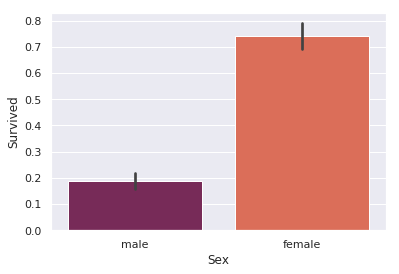

In [6]:
# Outputs the percentage of survivors for each gender
sns.barplot(x='Sex', y='Survived', data = data_train, palette="rocket")

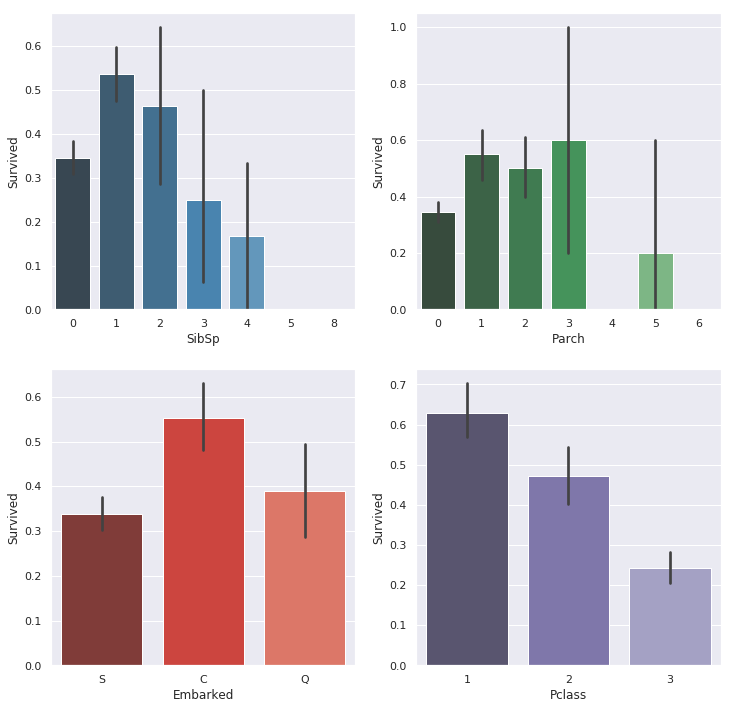

In [7]:
# Outputs the percentage of survivors for each value of the following features
f, ((ax_sibsp, ax_parch), (ax_embarked, ax_pclass)) = plt.subplots(2, 2,figsize=(12,12))
sns.barplot(x='SibSp', y='Survived', data=data_train, palette="Blues_d", ax = ax_sibsp)
sns.barplot(x='Parch', y='Survived', data=data_train, palette="Greens_d", ax = ax_parch)
sns.barplot(x='Embarked', y='Survived', data=data_train, palette="Reds_d", ax = ax_embarked)
sns.barplot(x='Pclass', y='Survived', data=data_train, palette="Purples_d", ax = ax_pclass)

The following four features SibSp, Parch, Embarked and Pclass seem to have an influential role in the survival likeliness.

Therefore those features are considered crucial for future model. Nevertheless, the final decision regarding the usage of a certain feature is only made after feature engineering (creation of new features) and further data analysis (for instance, correlation between features)

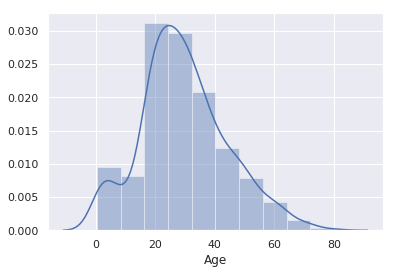

In [8]:
# Distribution plot for the feature Age
sns.distplot(data_train['Age'].dropna(), hist=True, bins=10)

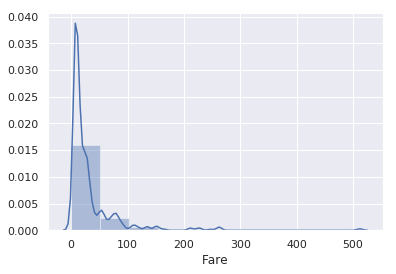

In [9]:
# Distribution plot for the feature Fare
sns.distplot(data_train['Fare'], hist=True, bins=10)

In [10]:
'''
Cabin feature analysis
    204 valid entries
    687 NaN
    
    147 unique values


Pclass    /    Fare     : Cabin Type
1st class / Highest fare: Cabin A to E 
2nd class               : Cabin D to F
3rd class / Lowest fare : Cabin D to G 

Create a new feature called CabinType which consists of the first letter present in Cabin
'''

for data in data_train_test:
    data['CabinType'] = data.Cabin.str.get(0)

cabin_types = data_train['CabinType'].unique()
cabin_types = [x for x in cabin_types if str(x) != 'nan']  # remove the NaN entries
cabin_types.sort() # sort by alphabetically order (important for visualization purposes)

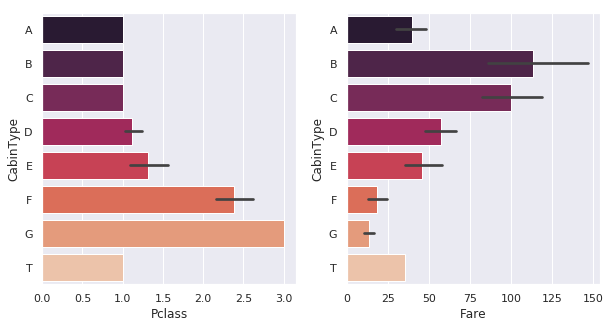

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
sns.barplot(y='CabinType', x='Pclass', data=data_train, palette="rocket", order=cabin_types, ax = ax1)
sns.barplot(y='CabinType', x='Fare', data=data_train, palette="rocket", order=cabin_types, ax = ax2)

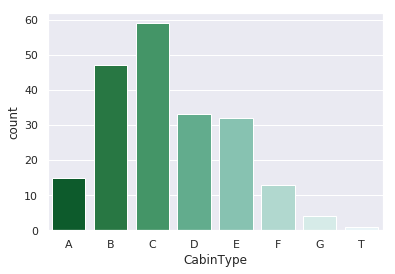

In [12]:
sns.countplot(x='CabinType', data=data_train, order=cabin_types, palette="BuGn_r")

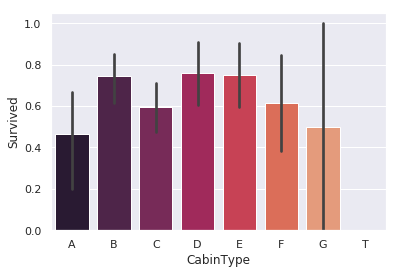

In [13]:
sns.barplot(x='CabinType', y='Survived', data = data_train, palette="rocket", order=cabin_types)

Consider removing CabinType feature (and also Cabin) since it has a lot of missing entries. Over 75% of the its training and testing entries are NaN. 

Also, considering the valid data, the type of cabin doesn't have a specific relationship with the target as can be seen in the bar plot above.

In [14]:
for data in data_train_test:
    data['TicketType'] = data.Ticket.str.split(" ", 1, expand=False).str.get(0)

print(data_train['TicketType'].value_counts())
print("Unique ticket types: ", data_train['TicketType'].nunique())

PC        60
C.A.      27
STON/O    12
A/5       10
W./C.      9
          ..
244358     1
11765      1
17466      1
113784     1
27849      1
Name: TicketType, Length: 557, dtype: int64
Unique ticket types:  557


In [15]:
for data in data_train_test:
    data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(data_train['Title'], data_train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: Title, dtype: int64


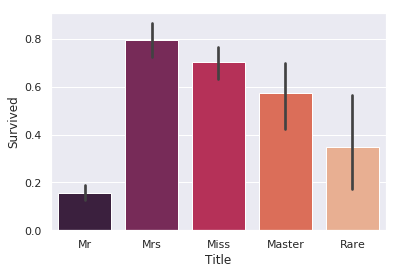

In [16]:
for data in data_train_test:
    data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data['Title'] = data['Title'].replace('Mlle', 'Miss')
    data['Title'] = data['Title'].replace('Ms', 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')

print(data_train['Title'].value_counts())
sns.barplot(x='Title', y='Survived', data = data_train, palette="rocket")

In [17]:
title_mapping = {"Master": 0, "Miss": 1, "Mr": 2, "Mrs": 3, "Rare": 4}
for data in data_train_test:
    data['Title'] = data['Title'].map(title_mapping)
    data['Title'] = data['Title'].fillna(0)  # review this fillna 0

Fill missing values for age and other features (use kneighbors for age probably)

   Title        Age
0      0   4.574167
1      1  21.845638
2      2  32.368090
3      3  35.788991
4      4  45.545455


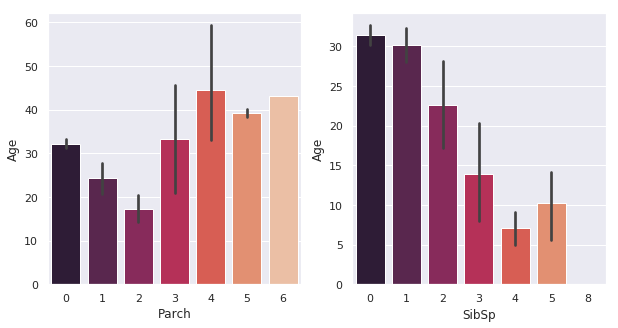

In [18]:
print(data_train[['Title', 'Age']].groupby(['Title'], as_index=False).mean())

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
sns.barplot(x='Parch', y='Age', palette="rocket", data=data_train, ax = ax1)
sns.barplot(x='SibSp', y='Age', palette="rocket", data=data_train, ax = ax2)

In [19]:
def knn_impute(target, attributes, num_neighbors):
    """ Replace the missing values within the target variable based on its k nearest neighbors identified with the
        attributes variables. If there is a problem in the parameters provided, returns None.
        @params:
            - target                        = a vector of n values with missing values that you want to impute.
            - attributes                    = a data frame of attributes with n rows to match the target variable
            - k_neighbors                   = the number of neighbors to look at to impute the missing values. It has to be a
                                              value between 1 and n.
        @returns:
            target_completed        = the vector of target values with missing value replaced. If there is a problem
                                      in the parameters, return None
        Function adapted from https://gist.github.com/YohanObadia/b310793cd22a4427faaadd9c381a5850
                                Yohan Obadia
    """

    # Get useful variables
    number_observations = len(target)

    # Check for possible errors
    if attributes.shape[0] != number_observations:
        print("The number of observations in the attributes variable is not matching the target variable length.")
        return None
    if num_neighbors > number_observations or num_neighbors < 1:
        print("The range of the number of neighbors is incorrect.")
        return None

    # Make sure the data are in the right format
    Y_train = target.dropna()        
    X_train = attributes[attributes.index.isin(Y_train.index)]

    Y_test = target[target.isnull()]
    X_test = attributes[attributes.index.isin(Y_test.index)]

    target_imputer = KNeighborsRegressor(n_neighbors=num_neighbors)
    target_imputer.fit(X_train, Y_train)
    predict = target_imputer.predict(X_test)
    
    predict = pd.Series(predict, index=X_test.index)
    
    return predict

In [20]:
for data in data_train_test:
    # features that influence age are: Title, Parch, Sibsp
    attributes_age = data[['Title', 'Parch', 'SibSp']]
    target_age = data['Age']

    predictions = knn_impute(target_age, attributes_age, 5)
    data['Age'][data['Age'].isnull()] = predictions

In [21]:
for data in data_train_test:
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace = True)
    data['Fare'].fillna(data['Fare'].median(), inplace = True)
    # review more complex ways to impute values
        
# Check if there are still NaNs in the training and test sets
print(data_train.isnull().sum())
print('-'*50)
print(data_test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
CabinType      687
TicketType       0
Title            0
dtype: int64
--------------------------------------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
CabinType      327
TicketType       0
Title            0
dtype: int64


Convert features to numeric formats

In [22]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinType,TicketType,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,NaN,A/5,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,PC,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,NaN,STON/O2.,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,113803,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,NaN,373450,2


In [23]:
labelencoder = LabelEncoder()

for data in data_train_test:
    data['Embarked'] = labelencoder.fit_transform(data['Embarked'])
    data['Sex'] = labelencoder.fit_transform(data['Sex'])

In [24]:
# review automatic way to divide into bins
data_train['FareBand'] = pd.qcut(data_train['Fare'], 3)
data_train[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 8.662]",0.198052
1,"(8.662, 26.0]",0.402778
2,"(26.0, 512.329]",0.559322


In [25]:
for data in data_train_test:
    data.loc[ data['Fare'] <= 8.662, 'Fare'] = 3
    data.loc[(data['Fare'] > 8.662) & (data['Fare'] <= 26), 'Fare'] = 2
    data.loc[ data['Fare'] > 26, 'Fare'] = 1
    data['Fare'] = data['Fare'].astype(int)

data_train = data_train.drop(['FareBand'], axis=1)
data_train_test = [data_train, data_test]

In [26]:
data_train['AgeBand'] = pd.cut(data_train['Age'], 5)
data_train[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(0.34, 16.336]",0.500000
1,"(16.336, 32.252]",0.338843
2,"(32.252, 48.168]",0.421801
3,"(48.168, 64.084]",0.434783
4,"(64.084, 80.0]",0.090909


In [27]:
for data in data_train_test:    
    data.loc[ data['Age'] <= 12, 'Age'] = 0
    data.loc[(data['Age'] > 12) & (data['Age'] <= 24), 'Age'] = 1
    data.loc[(data['Age'] > 24) & (data['Age'] <= 45), 'Age'] = 2
    data.loc[(data['Age'] > 45) & (data['Age'] <= 60), 'Age'] = 3
    data.loc[ data['Age'] > 60, 'Age']

data_train = data_train.drop(['AgeBand'], axis=1)
data_train_test = [data_train, data_test]

Further feature engineering:

In [28]:
# New feature called SocialStatus = Fare * Pclass
for data in data_train_test:
    data['SocialStatus'] = data.Pclass + data.Fare

    #Discrete variables
    data['FamilySize'] = data ['SibSp'] + data['Parch'] + 1
    data['IsAlone'] = 1 #initialize to yes/1 is alone
    data['IsAlone'].loc[data['FamilySize'] > 1] = 0 # now update to no/0 if family size is greater than 1
    
data_train.loc[:, ['SocialStatus', 'Pclass', 'Fare']].head(10)

,SocialStatus,Pclass,Fare
0,6,3,3
1,2,1,1
2,6,3,3
3,2,1,1
4,6,3,3
5,6,3,3
6,2,1,1
7,5,3,2
8,5,3,2
9,3,2,1


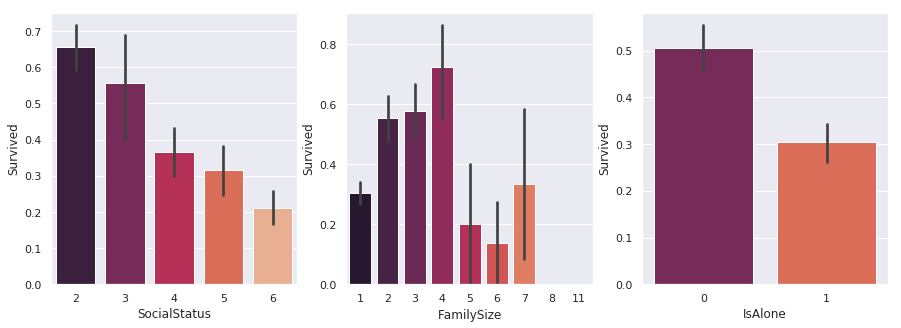

In [29]:
f, (ax_social, ax_fam, ax_alone) = plt.subplots(1, 3,figsize=(15,5))
sns.barplot(x='SocialStatus', y='Survived', palette="rocket", data=data_train, ax = ax_social)
sns.barplot(x='FamilySize', y='Survived', palette="rocket", data=data_train, ax = ax_fam)
sns.barplot(x='IsAlone', y='Survived', data = data_train, palette="rocket", ax = ax_alone)

In [30]:
data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinType,TicketType,Title,SocialStatus,FamilySize,IsAlone
0,892,3,"Kelly, Mr. James",1,2.0,0,0,330911,3,NaN,1,NaN,330911,2,6,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,3.0,1,0,363272,3,NaN,2,NaN,363272,3,6,2,0
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,2,NaN,1,NaN,240276,2,4,1,1
3,895,3,"Wirz, Mr. Albert",1,2.0,0,0,315154,2,NaN,2,NaN,315154,2,5,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,1.0,1,1,3101298,2,NaN,2,NaN,3101298,3,5,3,0


Feature selection

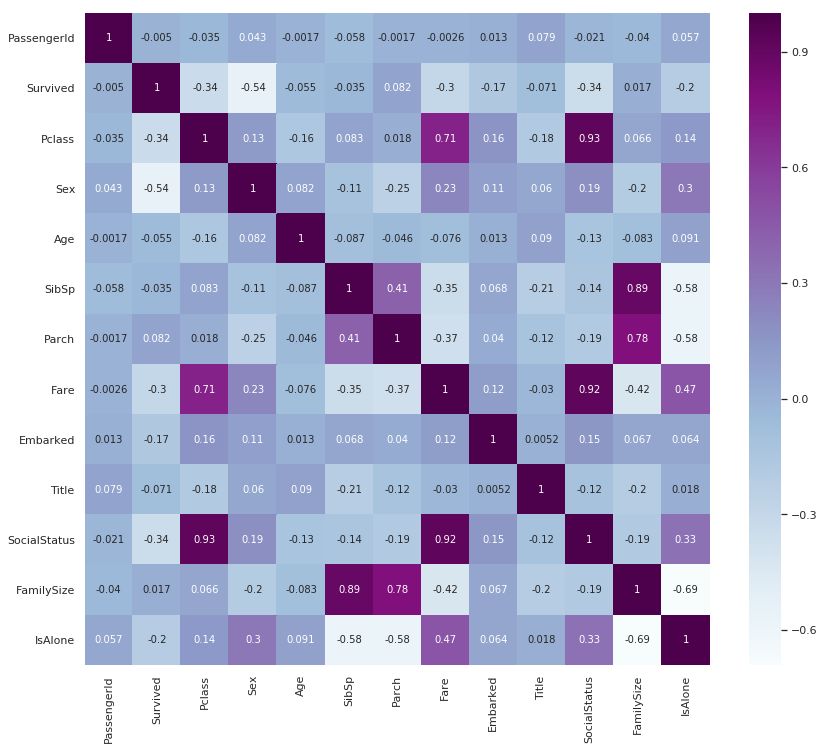

In [31]:
#get correlations of each features in dataset
corrmat = data_train.corr()
#top_corr_features = corrmat.index
plt.figure(figsize=(14,12))
#plot heat map
g=sns.heatmap(data_train.corr(),annot=True,cmap="BuPu")

In [32]:
# Select which features should be dropped
features_to_drop = ['Name', 'Ticket', 'Cabin', 'CabinType', 'TicketType']
for data in data_train_test:
    data.drop(columns=features_to_drop, inplace=True)

data_train.drop(columns=['PassengerId'], inplace=True)

In [33]:
data_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,SocialStatus,FamilySize,IsAlone
0,0,3,1,1.0,1,0,3,2,2,6,2,0
1,1,1,0,2.0,1,0,1,0,3,2,2,0
2,1,3,0,2.0,0,0,3,2,1,6,1,1
3,1,1,0,2.0,1,0,1,2,3,2,2,0
4,0,3,1,2.0,0,0,3,2,2,6,1,1


In [34]:
X_train = data_train.drop("Survived", axis=1)
Y_train = data_train["Survived"]
X_test = data_test.drop("PassengerId", axis=1)
X_train.shape, Y_train.shape, X_test.shape

((891, 11), (891,), (418, 11))

Further feature selection using Recursive Feature Elimination

In [35]:
#no of features
nof_list=np.arange(1,12)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]

model = RandomForestClassifier()

for n in range(len(nof_list)):
    X_train_aux, X_val, y_train_aux, y_val = train_test_split(X_train,Y_train, test_size = 0.3, random_state = 0)
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_aux,y_train_aux)
    X_val_rfe = rfe.transform(X_val)
    model.fit(X_train_rfe,y_train_aux)
    score = model.score(X_val_rfe,y_val)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 6
Score with 6 features: 0.843284


In [36]:

cols = list(X_train.columns)
model = RandomForestClassifier()
#Initializing RFE model
rfe = RFE(model, nof)
#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,Y_train)
X_rfe_test = rfe.transform(X_test)
#Fitting the data to model
model.fit(X_rfe,Y_train)
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['Pclass', 'Sex', 'Age', 'Title', 'SocialStatus', 'FamilySize'], dtype='object')


Random Forest hyperparameter tuning through GridSearch CV

In [37]:
# Choose the type of classifier. 
rf = RandomForestClassifier()

# Choose some parameter combinations to try
rf_parameters = {'n_estimators': [16, 18, 20, 22, 24, 26], 
              'max_features': ['sqrt'], 
              'criterion': ['entropy'],
              'max_depth': [5, 6], 
              'min_samples_split': [4, 5, 6],
              'min_samples_leaf': [6, 7, 8],
              'random_state': [0]
             }
# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj_rf = GridSearchCV(rf, rf_parameters, scoring=acc_scorer, cv = 3, verbose=2, n_jobs=-1, return_train_score =True)
grid_obj_rf = grid_obj_rf.fit(X_rfe, Y_train)

# Set the clf to the best combination of parameters
best_rf = grid_obj_rf.best_estimator_

rf_index_best = grid_obj_rf.cv_results_['mean_test_score'].argmax()
rf_best_test_score = grid_obj_rf.cv_results_['mean_test_score'][rf_index_best]
rf_train_score = grid_obj_rf.cv_results_['mean_train_score'][rf_index_best]

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 101 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:    9.7s finished


XGBoost hyperparameter tuning through GridSearch CV

In [38]:
xgb1 = xgb.XGBClassifier()

xgb_parameters = {'learning_rate': [0.0001, 0.001] ,
                  'n_estimators': [ 500, 1000, 1500, ],
                  'max_depth': [3, 4],
                  'min_child_weight': [0, 4],
                  'gamma': [ 0.0],
                  'colsample_bytree': [ 0.7],
                  'seed': [27],
                  'subsample': [0.7],
                  'scale_pos_weight': [1],
                  'reg_alpha': [0.00006]
                }

# Run the grid search
grid_obj_xgb = GridSearchCV(xgb1, xgb_parameters, scoring=acc_scorer, cv = 3, verbose=2, n_jobs=-1, return_train_score =True)
grid_obj_xgb = grid_obj_xgb.fit(X_rfe, Y_train)

# Set the clf to the best combination of parameters
best_xgb = grid_obj_xgb.best_estimator_

xgb_index_best = grid_obj_xgb.cv_results_['mean_test_score'].argmax()
xgb_best_test_score = grid_obj_xgb.cv_results_['mean_test_score'][xgb_index_best]
xgb_train_score = grid_obj_xgb.cv_results_['mean_train_score'][xgb_index_best]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   27.9s finished


Select the best algorithm (between the optimized Random Forest and XGBoost)

In [39]:
best_alg = best_xgb if xgb_best_test_score > rf_best_test_score else best_rf

In [40]:
best_alg.fit(X_rfe, Y_train)
Y_pred = best_alg.predict(X_rfe_test)

In [41]:
#best RF
submission = pd.DataFrame({'PassengerId': data_test['PassengerId'], 'Survived': Y_pred})
submission.to_csv('submission_best.csv',index=False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
